## Сбор данных с сайта "Яндекс Дзен"

In [22]:
import requests
from bs4 import BeautifulSoup
import json
import re
import pandas as pd
from datetime import datetime, timedelta
from sqlalchemy import create_engine
import traceback

cookies = {
    'news_lang': 'ru',
    'nc': 'tips=1669116675432%3Bfavorites-button:1',
    'sso_checked': '1',
    'yandex_login': '',
    'yandexuid': '4418883751668766953',
    '_yasc': 'bvYHi8GFr6wiVgwnzIGbRxV1jmn9isOWGNAJOxGLT7gEOCeBN0eS96hYsvk=',
    '_ym_uid': '16687727324320845',
    '_ym_d': '1668772732',
    'vid': 'c4a038b4868be81c',
    'Session_id': 'noauth:1669019784',
    'mda2_beacon': '1669019784785',
    '_ym_isad': '2',
    'tmr_lvid': '52390132f1b93bbd91c4c20fb582a7b7',
    'tmr_lvidTS': '1668772731725',
    'tmr_detect': '0%7C1669277547765',
}

headers = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'Accept-Language': 'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
    'Cache-Control': 'max-age=0',
    'Connection': 'keep-alive',
    # Requests sorts cookies= alphabetically
    # 'Cookie': 'news_lang=ru; nc=tips=1669116675432%3Bfavorites-button:1; sso_checked=1; yandex_login=; yandexuid=4418883751668766953; _yasc=bvYHi8GFr6wiVgwnzIGbRxV1jmn9isOWGNAJOxGLT7gEOCeBN0eS96hYsvk=; _ym_uid=16687727324320845; _ym_d=1668772732; vid=c4a038b4868be81c; Session_id=noauth:1669019784; mda2_beacon=1669019784785; _ym_isad=2; tmr_lvid=52390132f1b93bbd91c4c20fb582a7b7; tmr_lvidTS=1668772731725; tmr_detect=0%7C1669277547765',
    'Referer': 'https://dzen.ru/news?issue_tld=ru',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-User': '?1',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36',
    'sec-ch-ua': '"Google Chrome";v="107", "Chromium";v="107", "Not=A?Brand";v="24"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
}

# Функция для обработки и вывода времени
def parse_date(s_date):
    months = {'января': '01',
              'февраля': '02',
              'марта': '03',
              'апреля': '04',
              'мая': '05',
              'июня': '06',
              'июля': '07',
              'августа': '08',
              'сентября': '09',
              'октября': '10',
              'ноября': '11',
              'декабря': '12',
              }
    
    row_date = s_date.split(' в')[0]
    month_ = row_date.split(' ')[1].strip(' ')
    date_num = re.search(r'\d{2}', row_date).group(0)
    date = f"{date_num}.{months[month_]}.2022"
    return date

### Сбор новостей по рубрикам

In [23]:
def parse_rubrics():
    rubrics = ['Политика', 'Армия и оружие', 'Общество', 'ЖКХ', 'Религия', 'Экология', 'Здоровье', 'Путешествия', 
               'Транспорт', 'Экономика', 'Энергетика', 'Недвижимость', 'Финансы', 'В мире', 'Спорт', 'Автоспорт',
               'Баскетбол', 'Футбол', 'Хоккей', 'Фигурное катание', 'Происшествия', 'Культура', 'Театры', 'Музыка',
               'Кино', 'Технологии', 'Игры', 'Гаджеты', 'Интернет', 'Наука', 'Космос']
    rubrics_links = ['rubric/politics', 'rubric/army', 'rubric/society', 'rubric/communal', 'rubric/religion',
                     'rubric/ecology', 'rubric/health', 'rubric/travels', 'rubric/vehicle',  'rubric/business',
                     'rubric/energy', 'rubric/realty', 'rubric/finances', 'rubric/world', 'rubric/sport',
                     'rubric/auto_racing', 'rubric/basketball', 'rubric/football', 'rubric/hockey',
                     'rubric/figure_skating', 'rubric/incident', 'rubric/culture', 'rubric/theaters',
                     'rubric/music', 'rubric/movies', 'rubric/computers', 'rubric/games', 'rubric/gadgets',
                     'rubric/internet', 'rubric/science', 'rubric/cosmos']

    rubricsAndLinks = list(zip(rubrics, rubrics_links))
    df_rubricsAndLinks = pd.DataFrame(rubricsAndLinks, columns=['rubric', 'rubric_link'])

    session = requests.Session()
    session.headers.update(headers)
    session.cookies.update(cookies)

    dates = []
    times = []
    data = []
    stories = []

    for i, row in df_rubricsAndLinks.iterrows():
        link = row['rubric_link']
        r = session.get(f'https://dzen.ru/news/{link}?issue_tld=ru')

        soup = BeautifulSoup(r.text)
        script_text = soup.find_all('script')[3].contents[0]
        data = json.loads(re.search(r"window.Ya.Neo.dataSource=({.*?});", script_text, flags=re.S).group(1))

        story_rubric = row['rubric']
    
        for stories_top in data['news']['top']:
        
            story_id = stories_top['id']
            story_title = stories_top['title']
            story_annotation = stories_top['annotation']
            story_url = stories_top['url']
            instory_url = story_url.replace('/story/', '/instory/')
            story_time = stories_top['time']
            if 'вчера' in story_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', story_time) is not None:
                date = parse_date(story_time)
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
        
            stories.append([story_rubric, story_id, story_title, story_annotation, story_url, instory_url, story_time])
    
        for stories_feed in data['news']['feed']:
        
            story_id = stories_feed['id']
            story_title = stories_feed['title']
            story_annotation = stories_feed['annotation']
            story_url = stories_feed['url']
            instory_url = story_url.replace('/story/', '/instory/')
            story_time = stories_feed['time']
            if 'вчера' in story_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', story_time) is not None:
                date = parse_date(story_time)
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
        
            stories.append([story_rubric, story_id, story_title, story_annotation, story_url, instory_url, story_time])
    
    
    story_headers = ['rubric', 'id', 'title', 'annotation', 'story_url', 'instory_url', 'time']
    df_stories = pd.DataFrame(stories, columns=story_headers)

    return df_stories

### Сбор похожих новостей при переходе к каждой новости (instory) (с рубриками и подрубриками)

In [24]:
def parse_main():
    df_stories = parse_rubrics()
    df_instory = df_stories[['rubric', 'id', 'instory_url']]
    more_stories = []
    
    session = requests.Session()
    session.headers.update(headers)
    session.cookies.update(cookies)

    for i, row in df_stories.iterrows():
        url = row['instory_url']
        more = session.get(url)
        more_soup = BeautifulSoup(more.text)
        more_script_text = more_soup.find_all('script')[3].contents[0]
        more_data = json.loads(re.search(r"window.Ya.Neo.dataSource=({.*?});", more_script_text, flags=re.S).group(1))
                               
        more_info = more_data['news']['instoryPage'][0]
        docs = more_info['docs']
    
        more_rubric = row['rubric']
        more_idMain = row['id']
        more_instoryUrl = row['instory_url']
            
        for doc in docs:
        
            more_id = doc['docId']
            more_title = doc['title'][0]['text']  
            more_text = doc['text'][0]['text'] 
            more_source = doc['sourceName']
            more_url = doc['url']
            more_time = doc['time']
            if 'вчера' in more_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', more_time) is not None:
                date = parse_date(more_time)
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
   
            more_stories.append([more_rubric, more_idMain, more_title, more_text, more_source, more_instoryUrl, more_url, more_time])
            
    more_stories_headers = ['rubric', 'story_id', 'title', 'text', 'sourceName', 'instory_url', 'url', 'time']
    df_more_stories = pd.DataFrame(more_stories, columns=more_stories_headers)
    
    main_rubrics = []
    for i, row in df_more_stories.iterrows():
        if row['rubric'] == 'Политика' or row['rubric'] == 'Армия и оружие':
            main_rubric = 'Политика'
        elif row['rubric'] == 'Общество' or row['rubric'] == 'ЖКХ' or row['rubric'] == 'Религия' or row['rubric'] == 'Экология' or row['rubric'] == 'Здоровье' or row['rubric'] == 'Путешествия' or row['rubric'] == 'Транспорт':
            main_rubric = 'Общество'
        elif row['rubric'] == 'Экономика' or row['rubric'] == 'Энергетика' or row['rubric'] == 'Недвижимость' or row['rubric'] == 'Финансы':
            main_rubric = 'Экономика'
        elif row['rubric'] == 'В мире':
            main_rubric = 'В мире'
        elif row['rubric'] == 'Спорт' or row['rubric'] == 'Автоспорт' or row['rubric'] == 'Баскетбол' or row['rubric'] == 'Футбол' or row['rubric'] == 'Хоккей' or row['rubric'] == 'Фигурное катание':
            main_rubric = 'Спорт'
        elif row['rubric'] == 'Происшествия':
            main_rubric = 'Происшествия'
        elif row['rubric'] == 'Культура' or row['rubric'] == 'Театры' or row['rubric'] == 'Музыка' or row['rubric'] == 'Кино':
            main_rubric = 'Культура'
        elif row['rubric'] == 'Технологии' or row['rubric'] == 'Игры' or row['rubric'] == 'Гаджеты' or row['rubric'] == 'Интернет':
            main_rubric = 'Технологии'
        elif row['rubric'] == 'Наука' or row['rubric'] == 'Космос':
            main_rubric = 'Наука'
        else:
            main_rubric = 'Другое'
        
        main_rubrics.append(main_rubric)
                             
    df_more_stories.insert(loc=0, column='main_rubric', value=main_rubrics)
    return df_more_stories

### Сбор похожих новостей (только с рубриками)

In [25]:
def parse_main_1():
    df_stories = parse_rubrics()
    df_instory = df_stories[['rubric', 'id', 'instory_url']]
    more_stories = []
    
    session = requests.Session()
    session.headers.update(headers)
    session.cookies.update(cookies)

    for i, row in df_stories.iterrows():
        url = row['instory_url']
        more = session.get(url)
        more_soup = BeautifulSoup(more.text)
        more_script_text = more_soup.find_all('script')[3].contents[0]
        more_data = json.loads(re.search(r"window.Ya.Neo.dataSource=({.*?});", more_script_text, flags=re.S).group(1))
                               
        more_info = more_data['news']['instoryPage'][0]
        docs = more_info['docs']
    
        more_rubric = row['rubric']
        more_idMain = row['id']
        more_instoryUrl = row['instory_url']
            
        for doc in docs:
        
            more_id = doc['docId']
            more_title = doc['title'][0]['text']  
            more_text = doc['text'][0]['text'] 
            more_source = doc['sourceName']
            more_url = doc['url']
            more_time = doc['time']
            if 'вчера' in more_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', more_time) is not None:
                date = parse_date(more_time)
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
   
            more_stories.append([more_rubric, more_idMain, more_title, more_text, more_source, more_instoryUrl, more_url, more_time])
        
    more_stories_headers = ['rubric', 'story_id', 'title', 'text', 'sourceName', 'instory_url', 'url', 'time']
    df_more_stories = pd.DataFrame(more_stories, columns=more_stories_headers)

    return df_more_stories

## Разведочный анализ данных

In [26]:
%%time
df_parse = parse_main()
df_nlp = df_parse.loc[:, ['main_rubric','rubric','title','text']]

#df_nlp

IndexError: list index out of range

In [27]:
# Информация о данных
df_nlp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3365 entries, 2252 to 3429
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   main_rubric  3365 non-null   object
 1   rubric       3365 non-null   object
 2   title        3365 non-null   object
 3   text         3365 non-null   object
 4   text_prep    3365 non-null   object
 5   title_prep   3365 non-null   object
 6   text_stem    3365 non-null   object
 7   title_stem   3365 non-null   object
 8   text_sw      3365 non-null   object
 9   title_sw     3365 non-null   object
 10  text_lemm    3365 non-null   object
 11  title_lemm   3365 non-null   object
dtypes: object(12)
memory usage: 341.8+ KB


In [28]:
# Кол-во пропусков во всем датафрейме
df_nlp.isnull().sum()

main_rubric    0
rubric         0
title          0
text           0
text_prep      0
title_prep     0
text_stem      0
title_stem     0
text_sw        0
title_sw       0
text_lemm      0
title_lemm     0
dtype: int64

<div class="alert alert-success"><b>Пропусков в данных нет</b>

In [29]:
# Статистика распределения значений в столбце rubric в % виде
df_nlp['rubric'].value_counts(normalize=True)

Хоккей              0.076374
Происшествия        0.059435
Армия и оружие      0.051709
Политика            0.051412
В мире              0.039822
Общество            0.039525
Экономика           0.037741
Энергетика          0.037741
Культура            0.036256
Музыка              0.035958
Здоровье            0.034175
Футбол              0.032392
Наука               0.031501
Финансы             0.031501
Технологии          0.031204
Спорт               0.031204
Кино                0.030609
Транспорт           0.030015
Путешествия         0.030015
Космос              0.030015
Фигурное катание    0.029718
ЖКХ                 0.029718
Гаджеты             0.027340
Религия             0.024666
Баскетбол           0.022883
Игры                0.022288
Недвижимость        0.017533
Автоспорт           0.016345
Театры              0.014264
Интернет            0.011887
Экология            0.004755
Name: rubric, dtype: float64

In [30]:
# Статистика распределения этих значений в столбце main_rubric в % виде
df_nlp['main_rubric'].value_counts(normalize=True)

Спорт           0.208915
Общество        0.192868
Экономика       0.124517
Культура        0.117088
Политика        0.103120
Технологии      0.092719
Наука           0.061516
Происшествия    0.059435
В мире          0.039822
Name: main_rubric, dtype: float64

In [31]:
# Исследование столбца rubric
print('Кол-во уникальных значений: ', df_nlp['rubric'].nunique())
print('Список уникальных значений: ', df_nlp['rubric'].unique())
print('Статистика распределения значений: ', df_nlp['rubric'].value_counts(normalize=False))

Кол-во уникальных значений:  31
Список уникальных значений:  ['Происшествия' 'Политика' 'Армия и оружие' 'Общество' 'ЖКХ' 'Религия'
 'Экология' 'Здоровье' 'Путешествия' 'Транспорт' 'Экономика' 'Энергетика'
 'Недвижимость' 'Финансы' 'В мире' 'Спорт' 'Автоспорт' 'Баскетбол'
 'Футбол' 'Хоккей' 'Фигурное катание' 'Культура' 'Театры' 'Музыка' 'Кино'
 'Технологии' 'Игры' 'Гаджеты' 'Интернет' 'Наука' 'Космос']
Статистика распределения значений:  Хоккей              257
Происшествия        200
Армия и оружие      174
Политика            173
В мире              134
Общество            133
Экономика           127
Энергетика          127
Культура            122
Музыка              121
Здоровье            115
Футбол              109
Наука               106
Финансы             106
Технологии          105
Спорт               105
Кино                103
Транспорт           101
Путешествия         101
Космос              101
Фигурное катание    100
ЖКХ                 100
Гаджеты              92
Религ

In [32]:
# Исследование столбца main_rubric
print('Кол-во уникальных значений: ', df_nlp['main_rubric'].nunique())
print('Список уникальных значений: ', df_nlp['main_rubric'].unique())
print('Статистика распределения значений: ', df_nlp['main_rubric'].value_counts(normalize=False))

Кол-во уникальных значений:  9
Список уникальных значений:  ['Происшествия' 'Политика' 'Общество' 'Экономика' 'В мире' 'Спорт'
 'Культура' 'Технологии' 'Наука']
Статистика распределения значений:  Спорт           703
Общество        649
Экономика       419
Культура        394
Политика        347
Технологии      312
Наука           207
Происшествия    200
В мире          134
Name: main_rubric, dtype: int64


<div class="alert alert-success"><b>Вывод: вид задачи - многоклассовая классификация</b>

In [33]:
# Описательная статистика для всех признаков 
df_nlp.describe().T

,count,unique,top,freq
main_rubric,3365,9,Спорт,703
rubric,3365,31,Хоккей,257
title,3365,2826,Россия и Индия создадут независимый танкерный ...,6
text,3365,2865,"Фактически, Федеративная Республика Германия с...",6
text_prep,3365,2856,фактически федеративная республика германия ст...,6
title_prep,3365,2822,focus невероятный рост цен по всему спектру пр...,6
text_stem,3365,2851,фактическ федеративн республик герман станов о...,6
title_stem,3365,2809,транснефт получ заявк прокачк нефт польш герма...,6
text_sw,3365,2852,фактически федеративная республика германия ст...,6
title_sw,3365,2816,россия индия создадут независимый танкерный флот,6


### Визульный анализ

<AxesSubplot:>

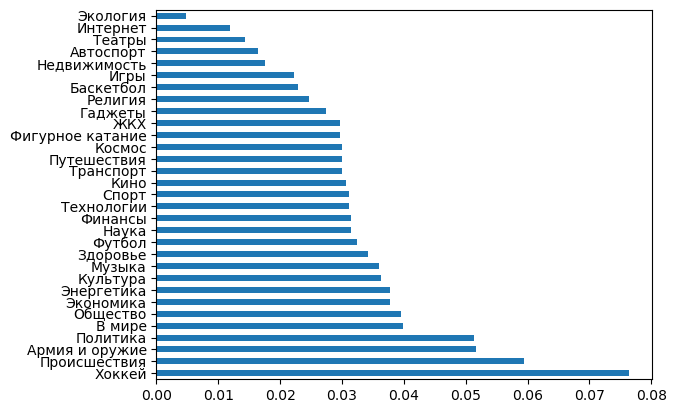

In [34]:
# Горизонтальная столбчатая диаграмма для столбца rubric
df_nlp['rubric'].value_counts(normalize=True).plot.barh()

<AxesSubplot:>

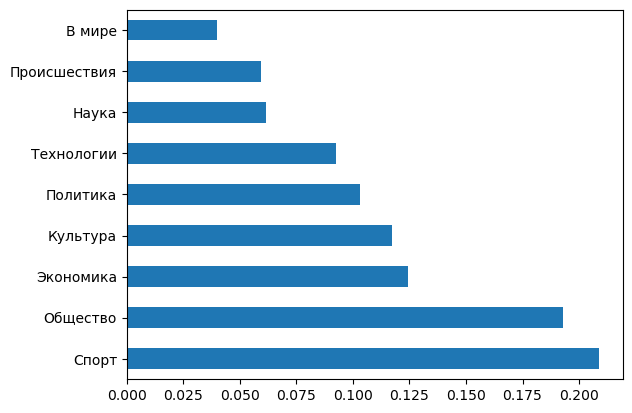

In [35]:
# Горизонтальная столбчатая диаграмма для столбца main_rubric
df_nlp['main_rubric'].value_counts(normalize=True).plot.barh()

In [36]:
df_nlp['rubric'].value_counts()

Хоккей              257
Происшествия        200
Армия и оружие      174
Политика            173
В мире              134
Общество            133
Экономика           127
Энергетика          127
Культура            122
Музыка              121
Здоровье            115
Футбол              109
Наука               106
Финансы             106
Технологии          105
Спорт               105
Кино                103
Транспорт           101
Путешествия         101
Космос              101
Фигурное катание    100
ЖКХ                 100
Гаджеты              92
Религия              83
Баскетбол            77
Игры                 75
Недвижимость         59
Автоспорт            55
Театры               48
Интернет             40
Экология             16
Name: rubric, dtype: int64

In [37]:
df_nlp['main_rubric'].value_counts()

Спорт           703
Общество        649
Экономика       419
Культура        394
Политика        347
Технологии      312
Наука           207
Происшествия    200
В мире          134
Name: main_rubric, dtype: int64

## Обработка естественного языка NLP

Действия, выполняемые в процессе:

* удаление пробельных символов;
* стемминг;
* удаление стоп-слов;
* лемматизация.

In [38]:
# Функция для удаления пробельных символов
import string
import re
from nltk.corpus import stopwords

def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])
def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])
def remove_multiple_spaces(text):
    return re.sub(r'\s+', ' ', text, flags=re.I)

def delete_char(): 
    prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in df_nlp['text']]
    prep_title = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in df_nlp['title']]
    df_nlp["text_prep"] = prep_text
    df_nlp["title_prep"] = prep_title
    return df_nlp


#Функция для стемматизации
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize

def stemmed_text():
    stemmer = SnowballStemmer("russian")
    russian_stopwords = stopwords.words("russian")
    russian_stopwords.extend(['…', '...', 'т.д.', 'т', 'д', '«', '»'])

    stemmed_texts_list = []
    stemmed_titles_list = []
    
    for text in df_nlp["text_prep"]:
        tokens = word_tokenize(text)
        stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
        text = " ".join(stemmed_tokens)
        stemmed_texts_list.append(text)
    
    df_nlp["text_stem"] = stemmed_texts_list
    
    for text in df_nlp["title_prep"]:
        tokens = word_tokenize(text)
        stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
        text = " ".join(stemmed_tokens)
        stemmed_titles_list.append(text)
    
    df_nlp["title_stem"] = stemmed_titles_list
    
    return df_nlp


#Функция для удаления стоп-слов
from nltk import word_tokenize

def stopword_text():
    russian_stopwords = stopwords.words("russian")
    russian_stopwords.extend(['…', '...', 'т.д.', 'т', 'д', '«', '»'])
    
    sw_texts_list = []
    sw_titles_list = []
    
    for text in df_nlp['text_prep']:
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
        text = " ".join(tokens)
        sw_texts_list.append(text)

    df_nlp["text_sw"] = sw_texts_list
    
    for text in df_nlp['title_prep']:
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
        text = " ".join(tokens)
        sw_titles_list.append(text)
        
    df_nlp["title_sw"] = sw_titles_list
    
    return df_nlp


#Функция для лемматизации
from pymystem3 import Mystem

def lemmatize_text():
    mystem = Mystem()
    
    lemm_texts_list = []
    lemm_titles_list = []
    
    russian_stopwords = stopwords.words("russian")
    russian_stopwords.extend(['…', '...', 'т.д.', 'т', 'д', '«', '»'])
    text1 = ""
    text2 = ""

    text_list = df_nlp['text_sw'].to_list()
    text_join = "joining".join(text_list)
    
    title_list = df_nlp['title_sw'].to_list()
    title_join = "joining".join(title_list)

    try:
        text_lem = mystem.lemmatize(text_join)
        tokens1 = [token for token in text_lem if token != ' ' and token not in russian_stopwords]
        text1 = " ".join(tokens1)
        
        title_lem = mystem.lemmatize(title_join)
        tokens2 = [token for token in title_lem if token != ' ' and token not in russian_stopwords]
        text2 = " ".join(tokens2)
        
    except Exception as e:
        print(e)

    text1_split = text1.split("joining")
    df_nlp["text_lemm"] = text1_split
    text2_split = text2.split("joining")
    df_nlp["title_lemm"] = text2_split
    
    return df_nlp

    
#Функция для балансировки классов
def nlp(df):
    delete_char()
    stemmed_text()
    stopword_text()
    lemmatize_text()
    
    df_pr = df.loc[df['main_rubric'] == 'Происшествия'].head(200)
    df_other = df.loc[df['main_rubric'] != 'Происшествия']
    df = pd.concat([df_pr, df_other])
    return df

In [39]:
df_nlp = nlp(df_nlp)
df_nlp

,main_rubric,rubric,title,text,text_prep,title_prep,text_stem,title_stem,text_sw,title_sw,text_lemm,title_lemm
2252,Происшествия,Происшествия,Число пострадавших при обрушении строительных ...,Количество пострадавших на стройке в Краснозна...,количество пострадавших на стройке в краснозна...,число пострадавших при обрушении строительных ...,количеств пострада стройк краснознаменск резул...,числ пострада обрушен строительн лес подмосков...,количество пострадавших стройке краснознаменск...,число пострадавших обрушении строительных лесо...,количество пострадать стройка краснознаменск р...,число пострадать обрушение строительный лес по...
2253,Происшествия,Происшествия,Число пострадавших при обрушении лесов в Красн...,"Инцидент произошёл накануне на лесах, установл...",инцидент произошёл накануне на лесах установле...,число пострадавших при обрушении лесов в красн...,инцидент произошел наканун лес установлен дом ...,числ пострада обрушен лес краснознаменск выросл,инцидент произошёл накануне лесах установленны...,число пострадавших обрушении лесов краснознаме...,инцидент происходить накануне лес устанавливат...,число пострадать обрушение лес краснознаменск ...
2254,Происшествия,Происшествия,Экстренные службы: число пострадавших при обру...,Число пострадавших при обрушении строительных ...,число пострадавших при обрушении строительных ...,экстренные службы число пострадавших при обруш...,числ пострада обрушен строительн лес подмосков...,экстрен служб числ пострада обрушен лес красно...,число пострадавших обрушении строительных лесо...,экстренные службы число пострадавших обрушении...,число пострадать обрушение строительный лес по...,экстренные служба число пострадать обрушение л...
2255,Происшествия,Происшествия,Число пострадавших при обрушении на стройке в ...,"Напомним, что инцидент на стройке в подмосковн...",напомним что инцидент на стройке в подмосковно...,число пострадавших при обрушении на стройке в ...,напомн инцидент стройк подмосковн краснознамен...,числ пострада обрушен стройк подмосков выросл,напомним инцидент стройке подмосковном красноз...,число пострадавших обрушении стройке подмосков...,напомним инцидент стройка подмосковный красноз...,число пострадать обрушение стройка подмосковье...
2256,Происшествия,Происшествия,Число пострадавших при обрушении лесов в Красн...,В результате обрушения строительных лесов в Кр...,в результате обрушения строительных лесов в кр...,число пострадавших при обрушении лесов в красн...,результат обрушен строительн лес краснознаменс...,числ пострада обрушен лес краснознаменск возросл,результате обрушения строительных лесов красно...,число пострадавших обрушении лесов краснознаме...,результате обрушение строительный лес краснозн...,число пострадать обрушение лес краснознаменск ...
...,...,...,...,...,...,...,...,...,...,...,...,...
3425,Наука,Космос,"Ученые объяснили, почему планеты не сталкивают...","Несмотря на огромную силу гравитации Солнца, п...",несмотря на огромную силу гравитации солнца пл...,ученые объяснили почему планеты не сталкиваютс...,несмотр огромн сил гравитац солнц планет солне...,учен объясн поч планет сталкива солнц воздейст...,несмотря огромную силу гравитации солнца плане...,ученые объяснили почему планеты сталкиваются с...,несмотря огромный сила гравитация солнце плане...,ученые объяснять почему планета сталкиваться с...
3426,Наука,Космос,"Ученые рассказали, что мешает планетам сталкив...","Главная причина, по которой планеты преодолева...",главная причина по которой планеты преодолеваю...,ученые рассказали что мешает планетам сталкива...,главн причин котор планет преодолева мощн грав...,учен рассказа меша планет сталкива солнц влиян...,главная причина которой планеты преодолевают м...,ученые рассказали мешает планетам сталкиваться...,главная причина который планета преодолевать м...,ученые рассказывать мешать планета сталкиватьс...
3427,Наука,Космос,Планеты преодолевают гравитацию Солнца и не ст...,Сила гравитации удерживает планеты Солнечной с...,сила гравитации удержив

<AxesSubplot:>

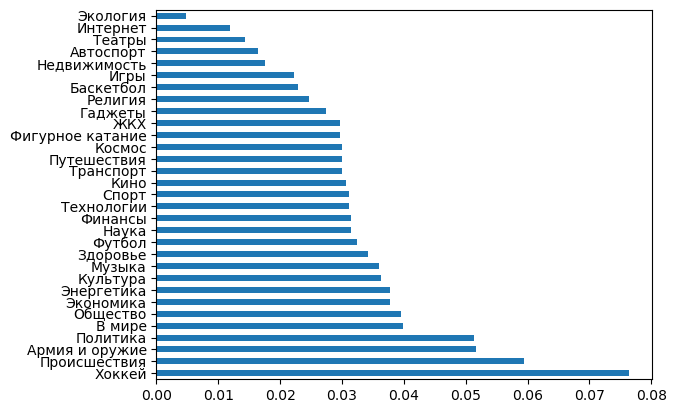

In [40]:
# Горизонтальная столбчатая диаграмма для rubric
df_nlp['rubric'].value_counts(normalize=True).plot.barh()

<AxesSubplot:>

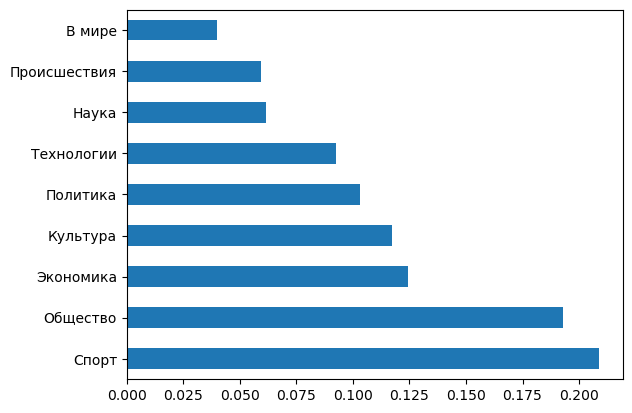

In [41]:
# Горизонтальная столбчатая диаграмма для main_rubric
df_nlp['main_rubric'].value_counts(normalize=True).plot.barh()

### Сохранение данных в формате csv

In [42]:
# Для mac
df_nlp.to_csv('/Users/user/Documents/ML.csv')

# Для win
#df_nlp.to_csv(r'C:\Users\User\Downloads\ML.csv')
# Выражение, добавляющее к БД только новые новости
#res = df1[~df1['url'].isin(df2['url'])]